In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

/tmp/ipykernel_24759/1226147920.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
import sys
sys.executable

'/home/joz608/.conda/envs/grc/bin/python3.8'

In [3]:
import sys
import os
import copy
import pathlib
import time
import gc

from tqdm import tqdm, trange
# from tqdm import trange

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

import torch
import torchvision
import torchvision.transforms as transforms

# import cuml

# for creating validation set
import sklearn
from sklearn.model_selection import train_test_split

%matplotlib inline
# %matplotlib inline
# %matplotlib inline
# %matplotlib qt

In [4]:
# base_dir = '/n/data1/hms/neurobio/sabatini/josh'

In [5]:
import sys

# base_dir = '/Users/josh/Documents'
base_dir = '../../../..'
sys.path.append(f'{base_dir}/github_repos')
# data_folder = f'../../data/final'
data_folder = f'../../data/training'
simclr_model_folder = f'../../models/simclr-modelsn'
model_performance_folder = f'../../reports/model-performance'
# sys.path.append(f'/media/rich/Home_Linux_partition/github_repos')
# dir_folders = r'/media/rich/bigSSD/for_Josh/GCAMP_ROI_Classifier_data/label_data'
# dir_folders = r'/users/Josh/Documents/Harvard/label_data'

%load_ext autoreload
%autoreload 2
from basic_neural_processing_modules import torch_helpers, math_functions, classification, h5_handling, plotting_helpers, indexing, misc, decomposition

# Must "pip install -e . in root project directory for this to work"
from GCaMP_ROI_classifier import util, dataset, models, training, augmentation

In [6]:
# !pip install numba
# !pip install copy
# !pip install scipy


## Import unlabeled training data

In [7]:
# data_unlabeled = h5_handling.simple_load(path=r'/media/rich/bigSSD/for_Josh/GCAMP_ROI_Classifier_data/masks_20211202_balanced.h5')
data_unlabeled = h5_handling.simple_load(path=f'{data_folder}/masks_20211202_balanced.h5')

masks_cat_raw = torch.as_tensor(np.concatenate((data_unlabeled['SYTmasks'], data_unlabeled['NPmasks'], data_unlabeled['RHmasks']), axis=0), dtype=torch.float32, device='cpu')

In [8]:
# data_labeled = h5_handling.simple_load(path=r'/media/rich/bigSSD/for_Josh/GCAMP_ROI_Classifier_data/masks_20211202_unbalanced.h5')

data_labeled = h5_handling.simple_load(path=f'{data_folder}/masks_20211202_unbalanced.h5')

masks_SYT = data_labeled['SYTmasks']
labels_SYT = classification.squeeze_integers(data_labeled['SYTlabels'])

nan_lst = np.concatenate(np.where(np.isnan(masks_SYT).sum(axis=-1).sum(axis=-1)))
non_nan = [_ for _ in range(masks_SYT.shape[0]) if _ not in nan_lst]
labels_SYT = labels_SYT[non_nan]
masks_SYT = masks_SYT[non_nan]

X_labeled_train_SYT, X_labeled_val_SYT, y_labeled_train_SYT, y_labeled_val_SYT = train_test_split(masks_SYT, labels_SYT, test_size = 0.2)

toss any NaNs

In [9]:
print(f'Number of masks: {masks_cat_raw.shape}')

ROIs_without_NaNs = torch.where(~torch.any(torch.any(torch.isnan(masks_cat_raw), dim=1), dim=1))[0]
masks_cat = masks_cat_raw[ROIs_without_NaNs]

print(f'Number of masks: {masks_cat.shape}')

Number of masks: torch.Size([711808, 36, 36])
Number of masks: torch.Size([711807, 36, 36])


## Import labeled training data

concatenated images shape: (9715, 32, 32)


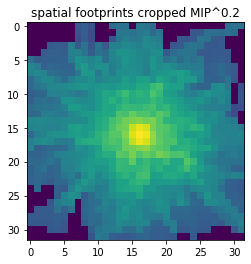

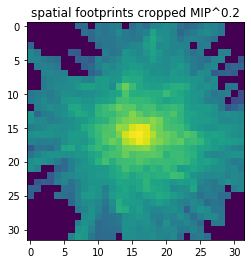

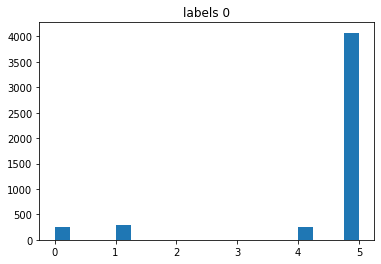

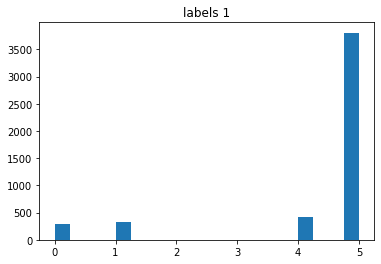

In [10]:
folders = [r'mouse 6_28 _ day 20200903/',
             r'mouse6_28 _ day20200815/']
fileNames_statFiles = [r'stat.npy']*len(folders)
paths_statFiles = [pathlib.Path(data_folder) / folders[ii] / fileNames_statFiles[ii] for ii in range(len(folders))]

sf_all = util.import_multiple_stat_files(   paths_statFiles=paths_statFiles,
                                            fileNames_statFiles=fileNames_statFiles,
                                            out_height_width=[32,32],
                                            max_footprint_width=241,
                                            plot_pref=True)
images_labeled_raw = np.concatenate(sf_all, axis=0)
images_labeled_raw = (images_labeled_raw / np.max(images_labeled_raw, axis=(1,2), keepdims=True)) * 1
print(f'concatenated images shape: {images_labeled_raw.shape}')

fileNames_labelFiles = ['labels_posthoc_filledIn_allCells.npy',
             'labels_posthoc_all.npy']
paths_labelFiles = [pathlib.Path(data_folder) / folders[ii] / fileNames_labelFiles[ii] for ii in range(len(folders))]

labels_all = util.import_multiple_label_files(paths_labelFiles=paths_labelFiles,
                                       plot_pref=True)
labels_raw = np.concatenate(labels_all)

assert np.alltrue([sf_all[ii].shape[0] == labels_all[ii].shape[0] for ii in range(len(sf_all))]) , 'num images in stat files does not correspond to num labels'

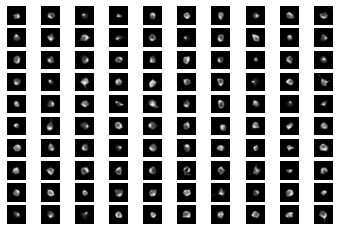

In [11]:
%matplotlib inline

plotting_helpers.plot_image_grid(images=images_labeled_raw,
                                labels=None,
                                grid_shape=(10,10), cmap=plt.get_cmap('gray'));

In [12]:
labels = classification.squeeze_integers(labels_raw)
images_labeled = images_labeled_raw[labels != 2]
labels = labels[labels != 2]
labels = classification.squeeze_integers(labels)

## Balance classes of inputs

In [13]:
duplicates = 1
balanced = True

images_dup = np.tile(images_labeled , (duplicates , 1 , 1))
labels_dup = np.tile(labels , (duplicates))

print(images_dup.shape)
print(labels_dup.shape)

if balanced:
    numToGetTo = np.sum(labels_dup==0)
    print(numToGetTo)
    for ii in np.array([1,2,3]):
  #     idxToDelete = np.cumsum(labels_dup==ii) <= (np.sum(labels_dup==ii) - numToGetTo)
        if ii==3:
            numToGetTo = np.sum(labels_dup==0)/1
        else:
            numToGetTo = np.sum(labels_dup==0)

        idxToDelete = (np.cumsum(labels_dup==ii) * (labels_dup==ii)) > numToGetTo
        images_dup = images_dup[idxToDelete==0,:,:]
        labels_dup = labels_dup[idxToDelete==0]





print(images_dup.shape)
print(labels_dup.shape)

numToGetTo = np.sum(labels_dup==0)
print(numToGetTo)

print(np.sum(labels_dup==0))
print(np.sum(labels_dup==1))
print(np.sum(labels_dup==4))
print(np.sum(labels_dup==5))
print(images_dup.shape)
print(labels_dup.shape)

(9714, 32, 32)
(9714,)
532
(2128, 32, 32)
(2128,)
532
532
532
0
0
(2128, 32, 32)
(2128,)


In [14]:
# create validation set

###### REMOVE WITH ENOUGH RAM
images = images_dup
labels = labels_dup

# X_labeled_train, X_labeled_val, y_labeled_train, y_labeled_val = train_test_split(images_dup, labels_dup, test_size = 0.3)
X_labeled_train, X_labeled_val, y_labeled_train, y_labeled_val = train_test_split(images_dup, labels_dup, test_size = 0.2)
# X_train, y_train = X_labeled_train, y_labeled_train

# X_labeled_val, X_test, y_labeled_val, y_test = train_test_split(X_labeled_val, y_labeled_val, test_size = 0.5)
X_val, X_test, y_val, y_test = train_test_split(X_labeled_val, y_labeled_val, test_size = 0.5)

(X_labeled_train.shape, y_labeled_train.shape), (X_labeled_val.shape, y_labeled_val.shape)

(((1702, 32, 32), (1702,)), ((426, 32, 32), (426,)))

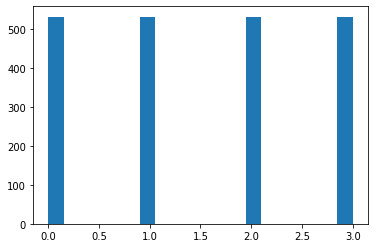

In [15]:
plt.figure()
plt.hist(labels_dup, 20);

In [16]:
images.shape

(2128, 32, 32)

# Train

In [17]:
# DEVICE = torch_helpers.set_device(use_GPU=True)
DEVICE = torch_helpers.set_device(use_GPU=False)

device: 'cpu'


### Define New model = model + pre-head + latent layer OR classification layer

In [18]:
# class ModelTackOn(torch.nn.Module):
#     def __init__(self, base_model, un_modified_model, pre_head_fc_sizes=[100], post_head_fc_sizes=[100], classifier_fc_sizes=None):
#             super(ModelTackOn, self).__init__()
#             self.base_model = base_model
#             final_base_layer = list(un_modified_model.children())[-1]
#             # final_base_layer = list(list(model.children())[-1].children())[-1]
#             # print(final_base_layer)

#             self.pre_head_fc_lst = []
#             self.post_head_fc_lst = []
#             self.classifier_fc_lst = []

#             self.init_prehead(final_base_layer, pre_head_fc_sizes)
#             self.init_posthead(pre_head_fc_sizes[-1], post_head_fc_sizes)
#             if classifier_fc_sizes is not None:
#                 self.init_classifier(pre_head_fc_sizes[-1], classifier_fc_sizes)
    
#     def init_prehead(self, prv_layer, pre_head_fc_sizes):
#         for i, pre_head_fc in enumerate(pre_head_fc_sizes):
#             if i == 0:
#                 in_features = prv_layer.in_features if hasattr(prv_layer,'in_features') else 1280
#             else:
#                 in_features = pre_head_fc_sizes[i - 1]
#             fc_layer = torch.nn.Linear(in_features=in_features, out_features=pre_head_fc)
#             self.add_module(f'PreHead_{i}', fc_layer)
#             self.pre_head_fc_lst.append(fc_layer)

# #             if i < len(pre_head_fc_sizes) - 1:
#             non_linearity = torch.nn.ReLU()
#             self.add_module(f'PreHead_{i}_NonLinearity', non_linearity)
#             self.pre_head_fc_lst.append(non_linearity)

#     def init_posthead(self, prv_size, post_head_fc_sizes):
#         for i, post_head_fc in enumerate(post_head_fc_sizes):
#             if i == 0:
#                 in_features = prv_size
#             else:
#                 in_features = post_head_fc_sizes[i - 1]
#             fc_layer = torch.nn.Linear(in_features=in_features, out_features=post_head_fc)
#             self.add_module(f'PostHead_{i}', fc_layer)
#             self.post_head_fc_lst.append(fc_layer)

#             if i < len(post_head_fc_sizes) - 1:
#                 non_linearity = torch.nn.ReLU()
#                 self.add_module(f'PostHead_{i}_NonLinearity', non_linearity)
#                 self.pre_head_fc_lst.append(non_linearity)
    
#     def init_classifier(self, prv_size, classifier_fc_sizes):
#             for i, classifier_fc in enumerate(classifier_fc_sizes):
#                 if i == 0:
#                     in_features = prv_size
#                 else:
#                     in_features = classifier_fc_sizes[i - 1]
#             fc_layer = torch.nn.Linear(in_features=in_features, out_features=classifier_fc)
#             self.add_module(f'Classifier_{i}', fc_layer)
#             self.classifier_fc_lst.append(fc_layer)

#     def reinit_classifier(self):
#         for i_layer, layer in enumerate(self.classifier_fc_lst):
#             layer.reset_parameters()
    
# #     def forward(self, X):
# #         interim = self.base_model(X)
# #         interim = self.get_head(interim)
# #         interim = self.get_latent(interim)
# #         return interim

#     def forward_classifier(self, X):
#         interim = self.base_model(X)
#         interim = self.get_head(interim)
#         interim = self.classify(interim)
#         return interim

#     def forward_latent(self, X):
#         interim = self.base_model(X)
#         interim = self.get_head(interim)
#         interim = self.get_latent(interim)
#         return interim


#     def get_head(self, base_out):
#         # print('base_out', base_out.shape)
#         head = base_out
#         for pre_head_layer in self.pre_head_fc_lst:
#           # print('pre_head_layer', pre_head_layer.in_features)
#           head = pre_head_layer(head)
#           # print('head', head.shape)
#         return head

#     def get_latent(self, head):
#         latent = head
#         for post_head_layer in self.post_head_fc_lst:
#             latent = post_head_layer(latent)
#         return latent

#     def classify(self, head):
#         logit = head
#         for classifier_layer in self.classifier_fc_lst:
#             logit = classifier_layer(logit)
#         return logit

#     def set_pre_head_grad(self, requires_grad=True):
#         for layer in self.pre_head_fc_lst:
#             for param in layer.parameters():
#                 param.requires_grad = requires_grad
                
#     def set_post_head_grad(self, requires_grad=True):
#         for layer in self.post_head_fc_lst:
#             for param in layer.parameters():
#                 param.requires_grad = requires_grad

#     def set_classifier_grad(self, requires_grad=True):
#         for layer in self.classifier_fc_lst:
#             for param in layer.parameters():
#                 param.requires_grad = requires_grad

#     def prep_contrast(self):
#         self.set_pre_head_grad(requires_grad=True)
#         self.set_post_head_grad(requires_grad=True)
#         self.set_classifier_grad(requires_grad=False)

#     def prep_classifier(self):
#         self.set_pre_head_grad(requires_grad=False)
#         self.set_post_head_grad(requires_grad=False)
#         self.set_classifier_grad(requires_grad=True)


In [19]:
from GCaMP_ROI_classifier.vicreg import main_vicreg as mvr
from GCaMP_ROI_classifier.vicreg.main_vicreg import *

In [20]:
from pathlib import Path
import argparse
import json
import math
import os
import sys
import time

import torch
import torch.nn.functional as F
from torch import nn, optim
import torch.distributed as dist
import torchvision.datasets as datasets

import GCaMP_ROI_classifier.vicreg.augmentations as aug
from GCaMP_ROI_classifier.vicreg.distributed import init_distributed_mode

import GCaMP_ROI_classifier.vicreg.resnet

parser = argparse.ArgumentParser('VICReg training script', parents=[mvr.get_arguments()])
args = parser.parse_args(['--device', 'cuda',
                          '--data-dir', '../../data',
                          '--exp-dir', '../../models/vicreg-models/fullaug',
                          '--batch-size', '800',
                          '--arch', 'resnet18'])
args.rank = args.local_rank


In [21]:
args.batch_size

800

In [22]:
from GCaMP_ROI_classifier.dataset import dataset_vicreg

In [23]:
# import torchvision.transforms    

# transforms = torch.nn.Sequential(
#     # torchvision.transforms.RandomHorizontalFlip(p=0.5),    
#     augmentation.ScaleDynamicRange(scaler_bounds=(0,1)), # just clamping, both this and clamping = normalizing (DEFAULT)
#     augmentation.WarpPoints(r=[0, 1],
#                             cx=[-0.5, 0.5],
#                             cy=[-0.5, 0.5], 
#                             dx=[-0.3, 0.0], 
#                             dy=[-0.3, 0.0], 
#                             n_warps=5,
#                             prob=1.0,
#                             img_size_in=[36, 36],
#                             img_size_out=[224, 224]),

    
#     augmentation.TileChannels(dim=0, n_channels=3),
# #     torchvision.transforms.Resize(size=(224,224), 
# #                                   interpolation=torchvision.transforms.InterpolationMode.BILINEAR), # To do or not to do (DEFAULT)
    
# )
    

# scripted_transforms = torch.jit.script(transforms)


import torchvision.transforms    

transforms = torch.nn.Sequential(
    torchvision.transforms.RandomHorizontalFlip(p=0.5),    
    torchvision.transforms.RandomAffine(
                                        degrees=(-180,180),
                                        translate=(0.15, 0.15), #0, .3, .45 (DEFAULT)
                                        scale=(0.6, 1.2), # no scale (1,1), (0.4, 1.5)
                                        shear=(-15, 15, -15, 15),
                                        interpolation=torchvision.transforms.InterpolationMode.BILINEAR, 
                                        fill=0, 
                                        fillcolor=None, 
                                        resample=None),
    augmentation.AddPoissonNoise(   #scaler_bounds=(10**(4.5), 10**(6.)),
                                    scaler_bounds=(10**(4), 10**(6)),
                                    prob=1,
                                    base=1000,
                                    scaling='log'),
    augmentation.AddGaussianNoise(  mean=0, 
                                    std=0.00015,
                                    prob=1),
    
    augmentation.ScaleDynamicRange(scaler_bounds=(0,1)),
    augmentation.WarpPoints(r=[0, 1],
                            cx=[-0.5, 0.5], 
                            cy=[-0.5, 0.5], 
                            dx=[-0.3, 0.0], 
                            dy=[-0.3, 0.0], 
                            n_warps=2,
                            prob=1.0,
                            img_size_in=[36, 36],
                            img_size_out=[224, 224]),

    
    augmentation.TileChannels(dim=0, n_channels=3),
    
)


scripted_transforms = torch.jit.script(transforms)

Warp Initialization took: 0.08106637001037598 s


In [ ]:
# args.rank, args.world_size

In [ ]:
# import os
# import sys
# import tempfile
# import torch
# import torch.distributed as dist
# import torch.nn as nn
# import torch.optim as optim
# import torch.multiprocessing as mp

# from torch.nn.parallel import DistributedDataParallel as DDP

# def setup(rank, world_size):
#     os.environ['MASTER_ADDR'] = 'localhost'
#     os.environ['MASTER_PORT'] = '12355'

#     # initialize the process group
#     dist.init_process_group("gloo", rank=rank, world_size=world_size)

# def cleanup():
#     dist.destroy_process_group()

# setup(args.rank, args.world_size)

In [24]:
# args.rank = args.local_rank
args.rank = 0

In [25]:
masks_cat.shape[0]//args.batch_size+1

890

In [26]:
from tqdm.notebook import tqdm, trange

torch.backends.cudnn.benchmark = True
# mvr.init_distributed_mode(args)
print(args)
gpu = torch.device(args.device)

if args.rank == 0:
    args.exp_dir.mkdir(parents=True, exist_ok=True)
    stats_file = open(args.exp_dir / "stats.txt", "a", buffering=1)
    print(" ".join(sys.argv))
    print(" ".join(sys.argv), file=stats_file)

# transforms = aug.TrainTransform()

dataset = dataset_vicreg(
                                torch.as_tensor(masks_cat, device='cpu', dtype=torch.float32), 
                                torch.as_tensor(torch.zeros(masks_cat.shape[0]), device='cpu', dtype=torch.float32),
                                transforms=[scripted_transforms, scripted_transforms],
                                DEVICE='cpu',
                                dtype_X=torch.float32,
                                dtype_y=torch.int64)
# dataset = datasets.ImageFolder(args.data_dir / "training", transforms)
# sampler = torch.utils.data.distributed.DistributedSampler(dataset, shuffle=True)
sampler = torch.utils.data.RandomSampler(dataset)
assert args.batch_size % args.world_size == 0
per_device_batch_size = args.batch_size // args.world_size
# loader = torch.utils.data.DataLoader(
#     dataset,
#     batch_size=per_device_batch_size,
# #     num_workers=args.num_workers,
# #     pin_memory=True,
#     sampler=sampler,
# )

loader = torch.utils.data.DataLoader( dataset,
#                                                 batch_size=int(pct_batch_size*X_train.shape[0]),
                                                batch_size=800,
                                                # shuffle=True,
                                                shuffle=True,
                                                drop_last=False,
                                                pin_memory=True,
                                                num_workers=16,
                                                persistent_workers=True,
                                                prefetch_factor=3
                                                )

model = mvr.VICReg(args).to(DEVICE)#cuda(gpu)
# model = nn.SyncBatchNorm.convert_sync_batchnorm(model)
# model = torch.nn.parallel.DistributedDataParallel(model, device_ids=[gpu])

Namespace(arch='resnet18', base_lr=0.2, batch_size=800, cov_coeff=1.0, data_dir=PosixPath('../../data'), device='cuda', dist_url='env://', epochs=100, exp_dir=PosixPath('../../models/vicreg-models/fullaug'), local_rank=-1, log_freq_time=60, mlp='8192-8192-8192', num_workers=10, out_features='512', rank=0, sim_coeff=25.0, std_coeff=25.0, wd=1e-06, world_size=1)
/home/joz608/.conda/envs/grc/lib/python3.8/site-packages/ipykernel_launcher.py -f /home/joz608/.local/share/jupyter/runtime/kernel-6b8a403b-e0b1-4286-8518-a98f926c31f1.json
0.weight
1.weight
1.bias
4.0.conv1.weight
4.0.bn1.weight
4.0.bn1.bias
4.0.conv2.weight
4.0.bn2.weight
4.0.bn2.bias
4.1.conv1.weight
4.1.bn1.weight
4.1.bn1.bias
4.1.conv2.weight
4.1.bn2.weight
4.1.bn2.bias
5.0.conv1.weight
5.0.bn1.weight
5.0.bn1.bias
5.0.conv2.weight
5.0.bn2.weight
5.0.bn2.bias
5.0.downsample.0.weight
5.0.downsample.1.weight
5.0.downsample.1.bias
5.1.conv1.weight
5.1.bn1.weight
5.1.bn1.bias
5.1.conv2.weight
5.1.bn2.weight
5.1.bn2.bias
6.0.conv1

In [27]:
optimizer = mvr.LARS(
    model.parameters(),
    lr=0,
    weight_decay=args.wd,
    weight_decay_filter=exclude_bias_and_norm,
    lars_adaptation_filter=exclude_bias_and_norm,
)

if (args.exp_dir / "model.pth").is_file():
    if args.rank == 0:
        print("resuming from checkpoint")
    ckpt = torch.load(args.exp_dir / "model.pth", map_location="cpu")
    start_epoch = ckpt["epoch"]
    model.load_state_dict(ckpt["model"])
    optimizer.load_state_dict(ckpt["optimizer"])
else:
    start_epoch = 0

resuming from checkpoint


RuntimeError: Error(s) in loading state_dict for VICReg:
	Missing key(s) in state_dict: "backbone.0.weight", "backbone.1.weight", "backbone.1.bias", "backbone.1.running_mean", "backbone.1.running_var", "backbone.4.0.conv1.weight", "backbone.4.0.bn1.weight", "backbone.4.0.bn1.bias", "backbone.4.0.bn1.running_mean", "backbone.4.0.bn1.running_var", "backbone.4.0.conv2.weight", "backbone.4.0.bn2.weight", "backbone.4.0.bn2.bias", "backbone.4.0.bn2.running_mean", "backbone.4.0.bn2.running_var", "backbone.4.1.conv1.weight", "backbone.4.1.bn1.weight", "backbone.4.1.bn1.bias", "backbone.4.1.bn1.running_mean", "backbone.4.1.bn1.running_var", "backbone.4.1.conv2.weight", "backbone.4.1.bn2.weight", "backbone.4.1.bn2.bias", "backbone.4.1.bn2.running_mean", "backbone.4.1.bn2.running_var", "backbone.5.0.conv1.weight", "backbone.5.0.bn1.weight", "backbone.5.0.bn1.bias", "backbone.5.0.bn1.running_mean", "backbone.5.0.bn1.running_var", "backbone.5.0.conv2.weight", "backbone.5.0.bn2.weight", "backbone.5.0.bn2.bias", "backbone.5.0.bn2.running_mean", "backbone.5.0.bn2.running_var", "backbone.5.0.downsample.0.weight", "backbone.5.0.downsample.1.weight", "backbone.5.0.downsample.1.bias", "backbone.5.0.downsample.1.running_mean", "backbone.5.0.downsample.1.running_var", "backbone.5.1.conv1.weight", "backbone.5.1.bn1.weight", "backbone.5.1.bn1.bias", "backbone.5.1.bn1.running_mean", "backbone.5.1.bn1.running_var", "backbone.5.1.conv2.weight", "backbone.5.1.bn2.weight", "backbone.5.1.bn2.bias", "backbone.5.1.bn2.running_mean", "backbone.5.1.bn2.running_var", "backbone.6.0.conv1.weight", "backbone.6.0.bn1.weight", "backbone.6.0.bn1.bias", "backbone.6.0.bn1.running_mean", "backbone.6.0.bn1.running_var", "backbone.6.0.conv2.weight", "backbone.6.0.bn2.weight", "backbone.6.0.bn2.bias", "backbone.6.0.bn2.running_mean", "backbone.6.0.bn2.running_var", "backbone.6.0.downsample.0.weight", "backbone.6.0.downsample.1.weight", "backbone.6.0.downsample.1.bias", "backbone.6.0.downsample.1.running_mean", "backbone.6.0.downsample.1.running_var", "backbone.6.1.conv1.weight", "backbone.6.1.bn1.weight", "backbone.6.1.bn1.bias", "backbone.6.1.bn1.running_mean", "backbone.6.1.bn1.running_var", "backbone.6.1.conv2.weight", "backbone.6.1.bn2.weight", "backbone.6.1.bn2.bias", "backbone.6.1.bn2.running_mean", "backbone.6.1.bn2.running_var", "backbone.7.0.conv1.weight", "backbone.7.0.bn1.weight", "backbone.7.0.bn1.bias", "backbone.7.0.bn1.running_mean", "backbone.7.0.bn1.running_var", "backbone.7.0.conv2.weight", "backbone.7.0.bn2.weight", "backbone.7.0.bn2.bias", "backbone.7.0.bn2.running_mean", "backbone.7.0.bn2.running_var", "backbone.7.0.downsample.0.weight", "backbone.7.0.downsample.1.weight", "backbone.7.0.downsample.1.bias", "backbone.7.0.downsample.1.running_mean", "backbone.7.0.downsample.1.running_var", "backbone.7.1.conv1.weight", "backbone.7.1.bn1.weight", "backbone.7.1.bn1.bias", "backbone.7.1.bn1.running_mean", "backbone.7.1.bn1.running_var", "backbone.7.1.conv2.weight", "backbone.7.1.bn2.weight", "backbone.7.1.bn2.bias", "backbone.7.1.bn2.running_mean", "backbone.7.1.bn2.running_var". 
	Unexpected key(s) in state_dict: "backbone.conv1.weight", "backbone.bn1.weight", "backbone.bn1.bias", "backbone.bn1.running_mean", "backbone.bn1.running_var", "backbone.bn1.num_batches_tracked", "backbone.layer1.0.conv1.weight", "backbone.layer1.0.bn1.weight", "backbone.layer1.0.bn1.bias", "backbone.layer1.0.bn1.running_mean", "backbone.layer1.0.bn1.running_var", "backbone.layer1.0.bn1.num_batches_tracked", "backbone.layer1.0.conv2.weight", "backbone.layer1.0.bn2.weight", "backbone.layer1.0.bn2.bias", "backbone.layer1.0.bn2.running_mean", "backbone.layer1.0.bn2.running_var", "backbone.layer1.0.bn2.num_batches_tracked", "backbone.layer1.1.conv1.weight", "backbone.layer1.1.bn1.weight", "backbone.layer1.1.bn1.bias", "backbone.layer1.1.bn1.running_mean", "backbone.layer1.1.bn1.running_var", "backbone.layer1.1.bn1.num_batches_tracked", "backbone.layer1.1.conv2.weight", "backbone.layer1.1.bn2.weight", "backbone.layer1.1.bn2.bias", "backbone.layer1.1.bn2.running_mean", "backbone.layer1.1.bn2.running_var", "backbone.layer1.1.bn2.num_batches_tracked", "backbone.layer2.0.conv1.weight", "backbone.layer2.0.bn1.weight", "backbone.layer2.0.bn1.bias", "backbone.layer2.0.bn1.running_mean", "backbone.layer2.0.bn1.running_var", "backbone.layer2.0.bn1.num_batches_tracked", "backbone.layer2.0.conv2.weight", "backbone.layer2.0.bn2.weight", "backbone.layer2.0.bn2.bias", "backbone.layer2.0.bn2.running_mean", "backbone.layer2.0.bn2.running_var", "backbone.layer2.0.bn2.num_batches_tracked", "backbone.layer2.0.downsample.0.weight", "backbone.layer2.0.downsample.1.weight", "backbone.layer2.0.downsample.1.bias", "backbone.layer2.0.downsample.1.running_mean", "backbone.layer2.0.downsample.1.running_var", "backbone.layer2.0.downsample.1.num_batches_tracked", "backbone.layer2.1.conv1.weight", "backbone.layer2.1.bn1.weight", "backbone.layer2.1.bn1.bias", "backbone.layer2.1.bn1.running_mean", "backbone.layer2.1.bn1.running_var", "backbone.layer2.1.bn1.num_batches_tracked", "backbone.layer2.1.conv2.weight", "backbone.layer2.1.bn2.weight", "backbone.layer2.1.bn2.bias", "backbone.layer2.1.bn2.running_mean", "backbone.layer2.1.bn2.running_var", "backbone.layer2.1.bn2.num_batches_tracked", "backbone.layer3.0.conv1.weight", "backbone.layer3.0.bn1.weight", "backbone.layer3.0.bn1.bias", "backbone.layer3.0.bn1.running_mean", "backbone.layer3.0.bn1.running_var", "backbone.layer3.0.bn1.num_batches_tracked", "backbone.layer3.0.conv2.weight", "backbone.layer3.0.bn2.weight", "backbone.layer3.0.bn2.bias", "backbone.layer3.0.bn2.running_mean", "backbone.layer3.0.bn2.running_var", "backbone.layer3.0.bn2.num_batches_tracked", "backbone.layer3.0.downsample.0.weight", "backbone.layer3.0.downsample.1.weight", "backbone.layer3.0.downsample.1.bias", "backbone.layer3.0.downsample.1.running_mean", "backbone.layer3.0.downsample.1.running_var", "backbone.layer3.0.downsample.1.num_batches_tracked", "backbone.layer3.1.conv1.weight", "backbone.layer3.1.bn1.weight", "backbone.layer3.1.bn1.bias", "backbone.layer3.1.bn1.running_mean", "backbone.layer3.1.bn1.running_var", "backbone.layer3.1.bn1.num_batches_tracked", "backbone.layer3.1.conv2.weight", "backbone.layer3.1.bn2.weight", "backbone.layer3.1.bn2.bias", "backbone.layer3.1.bn2.running_mean", "backbone.layer3.1.bn2.running_var", "backbone.layer3.1.bn2.num_batches_tracked", "backbone.layer4.0.conv1.weight", "backbone.layer4.0.bn1.weight", "backbone.layer4.0.bn1.bias", "backbone.layer4.0.bn1.running_mean", "backbone.layer4.0.bn1.running_var", "backbone.layer4.0.bn1.num_batches_tracked", "backbone.layer4.0.conv2.weight", "backbone.layer4.0.bn2.weight", "backbone.layer4.0.bn2.bias", "backbone.layer4.0.bn2.running_mean", "backbone.layer4.0.bn2.running_var", "backbone.layer4.0.bn2.num_batches_tracked", "backbone.layer4.0.downsample.0.weight", "backbone.layer4.0.downsample.1.weight", "backbone.layer4.0.downsample.1.bias", "backbone.layer4.0.downsample.1.running_mean", "backbone.layer4.0.downsample.1.running_var", "backbone.layer4.0.downsample.1.num_batches_tracked", "backbone.layer4.1.conv1.weight", "backbone.layer4.1.bn1.weight", "backbone.layer4.1.bn1.bias", "backbone.layer4.1.bn1.running_mean", "backbone.layer4.1.bn1.running_var", "backbone.layer4.1.bn1.num_batches_tracked", "backbone.layer4.1.conv2.weight", "backbone.layer4.1.bn2.weight", "backbone.layer4.1.bn2.bias", "backbone.layer4.1.bn2.running_mean", "backbone.layer4.1.bn2.running_var", "backbone.layer4.1.bn2.num_batches_tracked", "backbone.fc.weight", "backbone.fc.bias". 
	size mismatch for projector.0.weight: copying a param with shape torch.Size([8192, 1000]) from checkpoint, the shape in current model is torch.Size([8192, 512]).

In [ ]:
start_time = last_logging = time.time()
scaler = torch.cuda.amp.GradScaler()
for epoch in trange(start_epoch, args.epochs):
#     sampler.set_epoch(epoch)
#     for step, ((x, y), _) in enumerate(loader, start=epoch * len(loader)):
    for step, (x, y, _) in tqdm(enumerate(loader, start=epoch * len(loader)), total=len(loader)+1):
        x = x.cuda(gpu, non_blocking=True)
        y = y.cuda(gpu, non_blocking=True)
#         x = x.to(DEVICE)
#         y = y.to(DEVICE)

        lr = mvr.adjust_learning_rate(args, optimizer, loader, step)

        optimizer.zero_grad()
#         with torch.cuda.amp.autocast():
        loss = model.forward(x, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        current_time = time.time()
        if args.rank == 0 and current_time - last_logging > args.log_freq_time:
            stats = dict(
                epoch=epoch,
                step=step,
                loss=loss.item(),
                time=int(current_time - start_time),
                lr=lr,
            )
            print(json.dumps(stats))
            print(json.dumps(stats), file=stats_file)
            last_logging = current_time
    if args.rank == 0:
        state = dict(
            epoch=epoch + 1,
            model=model.state_dict(),
            optimizer=optimizer.state_dict(),
        )
        torch.save(state, args.exp_dir / "model.pth")
if args.rank == 0:
    torch.save(model.module.backbone.state_dict(), args.exp_dir / "resnet18.pth")

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 0, "step": 8, "loss": 24.422794342041016, "time": 61, "lr": 0.0005617977528089888}
{"epoch": 0, "step": 37, "loss": 23.326711654663086, "time": 122, "lr": 0.0025983146067415732}
{"epoch": 0, "step": 61, "loss": 23.00567054748535, "time": 186, "lr": 0.0042837078651685396}
{"epoch": 0, "step": 91, "loss": 22.710756301879883, "time": 247, "lr": 0.006390449438202247}
{"epoch": 0, "step": 126, "loss": 22.41522979736328, "time": 309, "lr": 0.008848314606741573}
{"epoch": 0, "step": 161, "loss": 22.119678497314453, "time": 370, "lr": 0.011306179775280898}
{"epoch": 0, "step": 196, "loss": 21.86425018310547, "time": 432, "lr": 0.013764044943820225}
{"epoch": 0, "step": 231, "loss": 21.681638717651367, "time": 494, "lr": 0.01622191011235955}
{"epoch": 0, "step": 266, "loss": 21.587114334106445, "time": 555, "lr": 0.018679775280898876}
{"epoch": 0, "step": 301, "loss": 21.53013801574707, "time": 617, "lr": 0.0211376404494382}
{"epoch": 0, "step": 336, "loss": 21.454315185546875, "time"

  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 1, "step": 890, "loss": 20.53070640563965, "time": 1695, "lr": 0.0625}
{"epoch": 1, "step": 923, "loss": 20.498779296875, "time": 1755, "lr": 0.06481741573033707}
{"epoch": 1, "step": 957, "loss": 20.440052032470703, "time": 1816, "lr": 0.06720505617977528}
{"epoch": 1, "step": 991, "loss": 20.348424911499023, "time": 1877, "lr": 0.06959269662921348}
{"epoch": 1, "step": 1025, "loss": 20.35577964782715, "time": 1938, "lr": 0.07198033707865169}
{"epoch": 1, "step": 1059, "loss": 20.353927612304688, "time": 1999, "lr": 0.07436797752808989}
{"epoch": 1, "step": 1093, "loss": 20.314987182617188, "time": 2060, "lr": 0.07675561797752808}
{"epoch": 1, "step": 1127, "loss": 20.168638229370117, "time": 2121, "lr": 0.07914325842696629}
{"epoch": 1, "step": 1161, "loss": 20.170412063598633, "time": 2182, "lr": 0.0815308988764045}
{"epoch": 1, "step": 1195, "loss": 20.25350570678711, "time": 2243, "lr": 0.0839185393258427}
{"epoch": 1, "step": 1229, "loss": 20.120542526245117, "time": 23

  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 2, "step": 1785, "loss": 19.7567081451416, "time": 3339, "lr": 0.12535112359550563}
{"epoch": 2, "step": 1819, "loss": 19.808719635009766, "time": 3400, "lr": 0.12773876404494383}
{"epoch": 2, "step": 1853, "loss": 19.75282859802246, "time": 3461, "lr": 0.130126404494382}
{"epoch": 2, "step": 1887, "loss": 19.668731689453125, "time": 3522, "lr": 0.13251404494382021}
{"epoch": 2, "step": 1921, "loss": 19.81216049194336, "time": 3583, "lr": 0.13490168539325842}
{"epoch": 2, "step": 1955, "loss": 19.673784255981445, "time": 3644, "lr": 0.13728932584269662}
{"epoch": 2, "step": 1989, "loss": 19.704254150390625, "time": 3705, "lr": 0.13967696629213483}
{"epoch": 2, "step": 2023, "loss": 19.70245933532715, "time": 3766, "lr": 0.14206460674157304}
{"epoch": 2, "step": 2057, "loss": 19.729106903076172, "time": 3826, "lr": 0.14445224719101124}
{"epoch": 2, "step": 2091, "loss": 19.65515899658203, "time": 3886, "lr": 0.14683988764044945}
{"epoch": 2, "step": 2125, "loss": 19.6508007049

  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 3, "step": 2670, "loss": 19.42906379699707, "time": 4949, "lr": 0.1875}
{"epoch": 3, "step": 2701, "loss": 19.477947235107422, "time": 5011, "lr": 0.18967696629213482}
{"epoch": 3, "step": 2735, "loss": 19.435747146606445, "time": 5071, "lr": 0.19206460674157302}
{"epoch": 3, "step": 2769, "loss": 19.377187728881836, "time": 5131, "lr": 0.19445224719101123}
{"epoch": 3, "step": 2803, "loss": 19.354286193847656, "time": 5193, "lr": 0.19683988764044943}
{"epoch": 3, "step": 2837, "loss": 19.298080444335938, "time": 5253, "lr": 0.19922752808988764}
{"epoch": 3, "step": 2871, "loss": 19.333053588867188, "time": 5314, "lr": 0.20161516853932585}
{"epoch": 3, "step": 2905, "loss": 19.28453826904297, "time": 5375, "lr": 0.20400280898876405}
{"epoch": 3, "step": 2939, "loss": 19.317495346069336, "time": 5436, "lr": 0.20639044943820226}
{"epoch": 3, "step": 2973, "loss": 19.29779624938965, "time": 5496, "lr": 0.20877808988764046}
{"epoch": 3, "step": 3007, "loss": 19.236072540283203, "

  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 4, "step": 3567, "loss": 19.161521911621094, "time": 6594, "lr": 0.2504915730337079}
{"epoch": 4, "step": 3602, "loss": 19.175312042236328, "time": 6656, "lr": 0.2529494382022472}
{"epoch": 4, "step": 3636, "loss": 19.058151245117188, "time": 6716, "lr": 0.25533707865168537}
{"epoch": 4, "step": 3670, "loss": 19.127132415771484, "time": 6777, "lr": 0.2577247191011236}
{"epoch": 4, "step": 3704, "loss": 19.165956497192383, "time": 6838, "lr": 0.2601123595505618}
{"epoch": 4, "step": 3738, "loss": 19.060232162475586, "time": 6899, "lr": 0.2625}
{"epoch": 4, "step": 3772, "loss": 19.08665657043457, "time": 6960, "lr": 0.2648876404494382}
{"epoch": 4, "step": 3806, "loss": 19.01225471496582, "time": 7021, "lr": 0.2672752808988764}
{"epoch": 4, "step": 3840, "loss": 19.038143157958984, "time": 7082, "lr": 0.2696629213483146}
{"epoch": 4, "step": 3874, "loss": 19.181087493896484, "time": 7143, "lr": 0.27205056179775283}
{"epoch": 4, "step": 3908, "loss": 19.00040626525879, "time": 

  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 5, "step": 4450, "loss": 18.900516510009766, "time": 8213, "lr": 0.3125}
{"epoch": 5, "step": 4485, "loss": 18.941612243652344, "time": 8274, "lr": 0.31495786516853935}
{"epoch": 5, "step": 4519, "loss": 18.918476104736328, "time": 8335, "lr": 0.31734550561797753}
{"epoch": 5, "step": 4553, "loss": 19.017074584960938, "time": 8396, "lr": 0.3197331460674157}
{"epoch": 5, "step": 4587, "loss": 18.868507385253906, "time": 8457, "lr": 0.32212078651685394}
{"epoch": 5, "step": 4621, "loss": 18.93260383605957, "time": 8518, "lr": 0.3245084269662921}
{"epoch": 5, "step": 4655, "loss": 18.818092346191406, "time": 8579, "lr": 0.32689606741573035}
{"epoch": 5, "step": 4689, "loss": 18.826852798461914, "time": 8640, "lr": 0.32928370786516853}
{"epoch": 5, "step": 4724, "loss": 18.752225875854492, "time": 8701, "lr": 0.3317415730337079}
{"epoch": 5, "step": 4758, "loss": 18.89386558532715, "time": 8762, "lr": 0.33412921348314606}
{"epoch": 5, "step": 4792, "loss": 18.818035125732422, "ti

In [31]:
X_data = X_labeled_train_SYT.copy()

transforms_validation = torch.nn.Sequential(
    augmentation.ScaleDynamicRange(scaler_bounds=(0,1)),
    torchvision.transforms.Resize(size=(224,224),
                                  interpolation=torchvision.transforms.InterpolationMode.BILINEAR), 
    augmentation.TileChannels(dim=0, n_channels=3),
)

scripted_transforms_validation = torch.jit.script(transforms_validation)

dataset_labeled_train = dataset_vicreg(
                                torch.as_tensor(X_data, device='cpu', dtype=torch.float32), 
                                torch.as_tensor(torch.zeros(X_data.shape[0]), device='cpu', dtype=torch.float32),
                                transforms=[scripted_transforms_validation, scripted_transforms_validation],
                                DEVICE='cpu',
                                dtype_X=torch.float32,
                                dtype_y=torch.int64)
dataloader_labeled_train = torch.utils.data.DataLoader(dataset_labeled_train,
                                                batch_size=100,
                                                shuffle=False,
                                                drop_last=False,
                                                pin_memory=False,
                                                num_workers=0,
                                                persistent_workers=False,
                                                )

latents = torch.cat([(model.backbone(data[0].to(DEVICE))).detach().cpu() for data in tqdm(dataloader_labeled_train)], dim=0)


  0%|          | 0/548 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
latents.shape

<IPython.core.display.Javascript object>


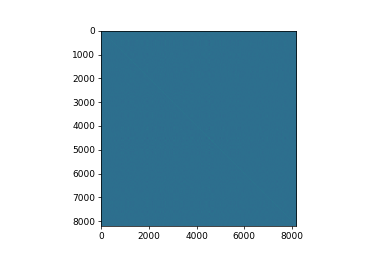

In [31]:
%matplotlib notebook

from basic_neural_processing_modules import similarity, decomposition

pairs = similarity.pairwise_similarity(latents.numpy())

plt.figure()
plt.imshow(pairs)

In [32]:
# dtp = decomposition.torch_pca(latents)[0]

# plt.figure()
# plt.plot(dtp)


In [33]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(latents)

PCA()

<IPython.core.display.Javascript object>


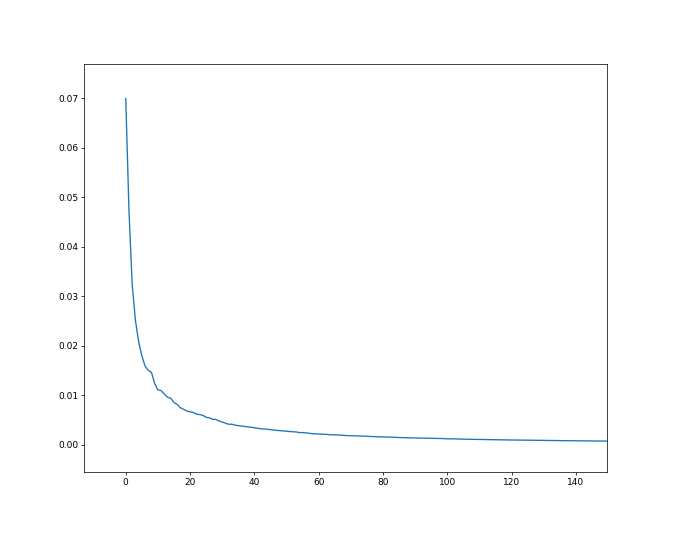

In [37]:
plt.figure()
plt.plot(pca.explained_variance_ratio_)
plt.yscale('linear')

<IPython.core.display.Javascript object>


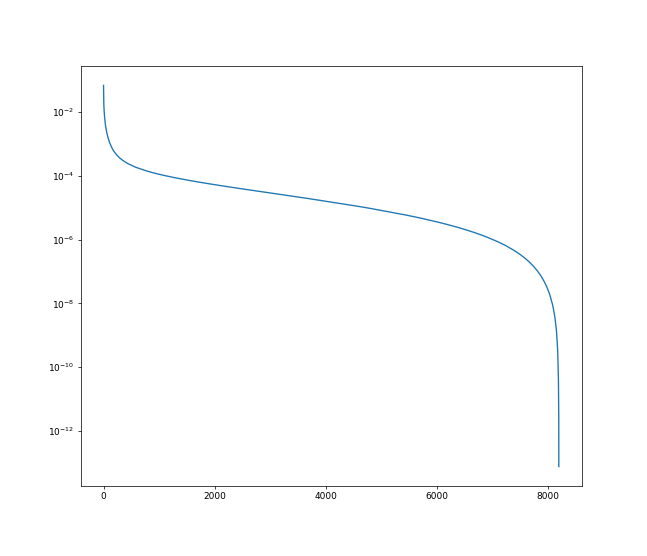

In [35]:
plt.figure()
plt.plot(pca.explained_variance_ratio_)
plt.yscale('log')

In [36]:
import umap
# import sns
# sns.set(style='white', context='poster', rc={'figure.figsize':(14,10)})
fit = umap.UMAP()
%time u = fit.fit_transform(latents)

CPU times: user 8min 57s, sys: 29.7 s, total: 9min 27s
Wall time: 58.9 s


In [38]:
import pandas as pd
xy_df = pd.DataFrame(u, columns=['x', 'y'])
xy_df['x_min'] = xy_df['x'].min()
xy_df['x_max'] = xy_df['x'].max()
xy_df['y_min'] = xy_df['y'].min()
xy_df['y_max'] = xy_df['y'].max()

xy_df['x_mm'] = (xy_df['x'] - xy_df['x_min']) / (xy_df['x_max'] - xy_df['x_min'])
xy_df['y_mm'] = (xy_df['y'] - xy_df['y_min']) / (xy_df['y_max'] - xy_df['y_min'])

xy_df['x_mmf'] = np.floor(xy_df['x_mm']*20)
xy_df['y_mmf'] = np.floor(xy_df['y_mm']*20)

xy_df['mmf'] = xy_df['x_mmf'].astype(str) + '_' + xy_df['y_mmf'].astype(str)
smpl_imgs = xy_df.groupby('mmf').sample(1)

In [39]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def scl_to_bnd(x, bound_high):
    mx = x.max(axis=0, keepdims=True)
    mn = x.min(axis=0, keepdims=True)
    scl = (x - mn)*(bound_high-1)/(mx - mn)
    return scl, mn, mx

bound_high = 1000
bounded_features = scl_to_bnd(u, bound_high)
inx_lst = list(smpl_imgs.index)
img_lst = X_data[inx_lst]
x = bounded_features[0][inx_lst, 0]
y = bounded_features[0][inx_lst, 1]

In [40]:
def getImage(img):
    return OffsetImage(img, cmap='gray')

<IPython.core.display.Javascript object>


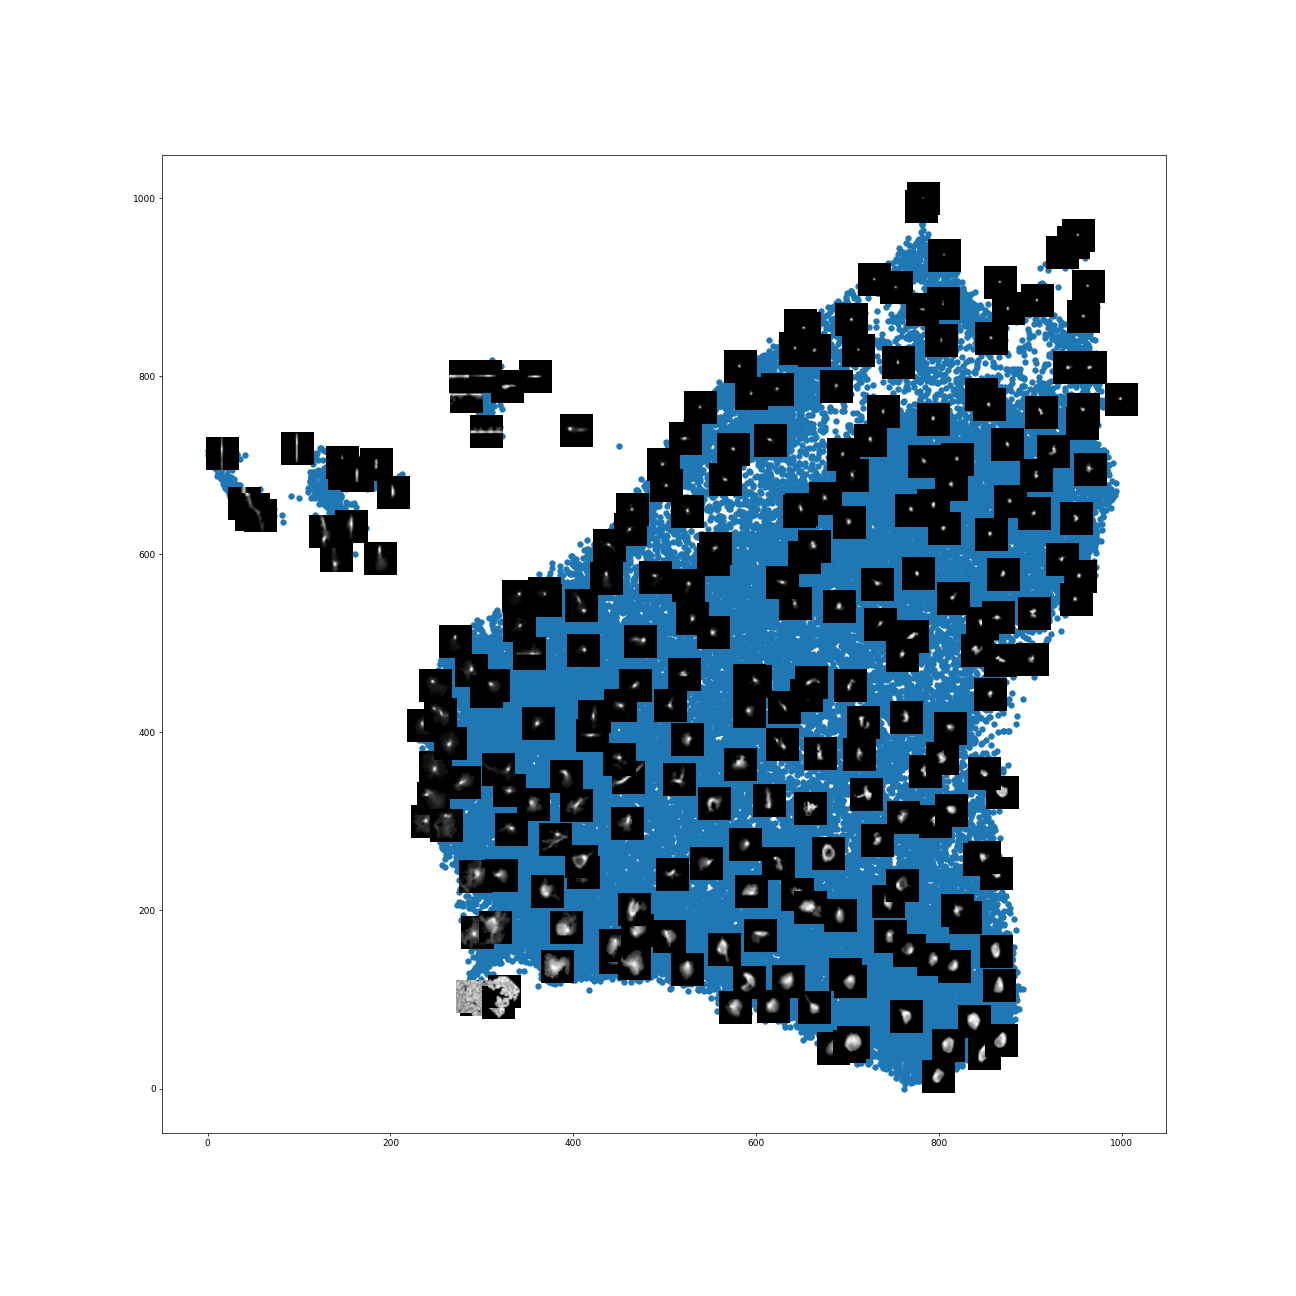

In [41]:
%matplotlib notebook
# plt.figure()
# plt.scatter(u[:,0], u[:,1])
# plt.title('UMAP');

fig, ax = plt.subplots(figsize=(20,20))

ax.scatter(bounded_features[0][:,0], bounded_features[0][:,1], cmap=plt.get_cmap('tab10'))
ax.scatter(x, y)

for x0, y0, path in zip(x, y, img_lst):
    ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
    ax.add_artist(ab)


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

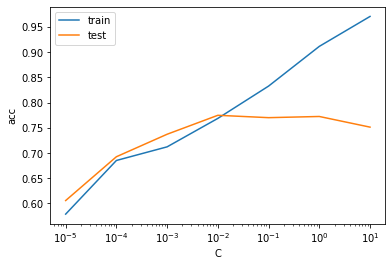

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

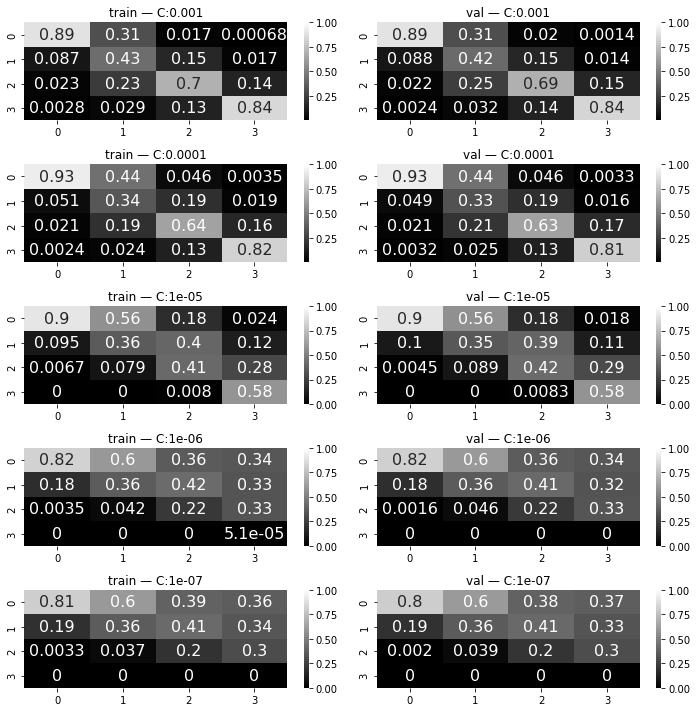

In [29]:
transforms_validation = torch.nn.Sequential(
    augmentation.ScaleDynamicRange(scaler_bounds=(0,1)),
    torchvision.transforms.Resize(size=(224,224),
                                  interpolation=torchvision.transforms.InterpolationMode.BILINEAR), 
    augmentation.TileChannels(dim=0, n_channels=3),
#     augmentation.Normalize(  means=[0.485, 0.456, 0.406],
#                              stds=[0.229, 0.224, 0.225]),
#     torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                      std=[0.229, 0.224, 0.225],
#                                      inplace=False),
)
scripted_transforms_validation = torch.jit.script(transforms_validation)
# scripted_transforms = transforms


dataset_labeled_train = dataset_vicreg(
                                torch.as_tensor(X_labeled_train, device='cpu', dtype=torch.float32), 
                                torch.as_tensor(torch.zeros(X_labeled_train.shape[0]), device='cpu', dtype=torch.float32),
                                transforms=[scripted_transforms_validation, scripted_transforms_validation],
                                DEVICE='cpu',
                                dtype_X=torch.float32,
                                dtype_y=torch.int64)
dataset_labeled_val = dataset_vicreg(
                                torch.as_tensor(X_labeled_val, device='cpu', dtype=torch.float32), 
                                torch.as_tensor(torch.zeros(X_labeled_val.shape[0]), device='cpu', dtype=torch.float32),
                                transforms=[scripted_transforms_validation, scripted_transforms_validation],
                                DEVICE='cpu',
                                dtype_X=torch.float32,
                                dtype_y=torch.int64
                                    )
dataloader_labeled_train = torch.utils.data.DataLoader( dataset_labeled_train,
                                                    batch_size=800,
                                                    shuffle=False,
                                                    drop_last=False
                                                    )
dataloader_labeled_val = torch.utils.data.DataLoader( dataset_labeled_val,
                                                    batch_size=800,
                                                    shuffle=False,
                                                    drop_last=False,
                                                    )


model.eval()
model.to(DEVICE)
features_train = torch.cat([(model.backbone(data[0].to(DEVICE))).detach().cpu() for data in tqdm(dataloader_labeled_train)], dim=0)
features_val   = torch.cat([(model.backbone(data[0].to(DEVICE))).detach().cpu() for data in tqdm(dataloader_labeled_val)], dim=0)


acc_train, acc_val = [], []
# C_toUse = np.array([1000,100,10,1,0.1,0.01,0.001,0.0001,0.00001])
C_toUse = np.array([10,1,0.1,0.01,0.001,0.0001,0.00001])
for C in C_toUse:
#     print(f'C = {C}')
    logreg = sklearn.linear_model.LogisticRegression(solver='liblinear', max_iter=800, C=C)
#     tic = time.time()
#     logreg.fit(features_train, y_labeled_train_SYT)
    logreg.fit(features_train, y_labeled_train)
#     print(f'time: {time.time() - tic}')
#     acc = logreg.score(features_train, y_labeled_train_SYT)
    acc = logreg.score(features_train, y_labeled_train)
    acc_train.append(acc)
#     print(f'acc_train: {acc}')
#     acc = logreg.score(features_val, y_labeled_val_SYT)
    acc = logreg.score(features_val, y_labeled_val)
    acc_val.append(acc)
#     print(f'acc_val: {acc}')
#     print('')
    

plt.figure()
plt.plot(C_toUse, acc_train)
plt.plot(C_toUse, acc_val)
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('acc')
plt.legend(['train', 'test']);
plt.show();

plt.figure()

from sklearn.model_selection import ShuffleSplit
splitter = ShuffleSplit(n_splits=50)
all_split_inx = list(splitter.split(features_train))

train_X = [features_train[_[0]] for _ in all_split_inx]
train_y = [y_labeled_train[_[0]] for _ in all_split_inx]
# train_y = [y_labeled_train_SYT[_[0]] for _ in all_split_inx]
test_X = [features_train[_[1]] for _ in all_split_inx]
test_y = [y_labeled_train[_[1]] for _ in all_split_inx]
# test_y = [y_labeled_train_SYT[_[1]] for _ in all_split_inx]

%matplotlib inline

c_lst = [1e-3, 1e-4, 1e-5, 1e-6, 1e-7]

fig, ax = plt.subplots(len(c_lst), 2, figsize=(10,10))
# plt.suptitle(f'{model_file_name}')

for ic, c in enumerate(c_lst):
    train_cms = []
    test_cms = []
    for inx_split in trange(len(train_X)):
        tmp_train_X = train_X[inx_split]
        tmp_train_y = train_y[inx_split]
        
        tmp_test_X = test_X[inx_split]
        tmp_test_y = test_y[inx_split]
        
        logreg = sklearn.linear_model.LogisticRegression(solver='liblinear', max_iter=800, C=c).fit(tmp_train_X, tmp_train_y)
        
        
        
        
        
        proba = logreg.predict_proba(tmp_train_X)

        preds = np.argmax(proba, axis=1)
        cm = classification.confusion_matrix(preds, tmp_train_y)
        train_cms.append(cm)

#         plt.figure()
#         sns.heatmap(cm, annot=True, annot_kws={"size": 16}, vmax=1., cmap=plt.get_cmap('gray'))
#         plt.title('train');
        
        proba = logreg.predict_proba(tmp_test_X)
        preds = np.argmax(proba, axis=1)
        cm = classification.confusion_matrix(preds, tmp_test_y)
        test_cms.append(cm)
        
#         plt.figure()
#         sns.heatmap(cm, annot=True, annot_kws={"size": 16}, vmax=1., cmap=plt.get_cmap('gray'))
#         plt.title('val');

    sns.heatmap(np.mean(train_cms,axis=0), annot=True, annot_kws={"size": 16}, vmax=1., cmap=plt.get_cmap('gray'), ax=ax[ic, 0])
    ax[ic, 0].set_title(f'train — C:{c}');

    sns.heatmap(np.mean(test_cms,axis=0), annot=True, annot_kws={"size": 16}, vmax=1., cmap=plt.get_cmap('gray'), ax=ax[ic, 1])
    ax[ic, 1].set_title(f'val — C:{c}');

plt.tight_layout()
plt.savefig(args.exp_dir / "confusion_matrices3.png")

In [55]:
# model

In [53]:

# parser = argparse.ArgumentParser('VICReg training script', parents=[mvr.get_arguments()])
# args = parser.parse_args(['--device', 'cuda',
#                           '--data-dir', '../../data',
#                           '--exp-dir', '../../models/vicreg-models/fullaug',
#                           '--batch-size', '800',
#                           '--arch', 'resnet18'])
# args.rank = args.local_rank
# from GCaMP_ROI_classifier.dataset import dataset_vicreg
# from tqdm.notebook import tqdm, trange

# torch.backends.cudnn.benchmark = True
# # mvr.init_distributed_mode(args)
# print(args)
# gpu = torch.device(args.device)

# if args.rank == 0:
#     args.exp_dir.mkdir(parents=True, exist_ok=True)
#     print(" ".join(sys.argv))
#     print(" ".join(sys.argv), file=stats_file)

# # transforms = aug.TrainTransform()

# dataset = dataset_vicreg(
#                                 torch.as_tensor(masks_cat, device='cpu', dtype=torch.float32), 
#                                 torch.as_tensor(torch.zeros(masks_cat.shape[0]), device='cpu', dtype=torch.float32),
#                                 transforms=[scripted_transforms, scripted_transforms],
#                                 DEVICE='cpu',
#                                 dtype_X=torch.float32,
#                                 dtype_y=torch.int64)

# sampler = torch.utils.data.RandomSampler(dataset)
# assert args.batch_size % args.world_size == 0
# per_device_batch_size = args.batch_size // args.world_size
# # loader = torch.utils.data.DataLoader(
# #     dataset,
# #     batch_size=per_device_batch_size,
# # #     num_workers=args.num_workers,
# # #     pin_memory=True,
# #     sampler=sampler,
# # )

# loader = torch.utils.data.DataLoader( dataset,
# #                                                 batch_size=int(pct_batch_size*X_train.shape[0]),
#                                                 batch_size=800,
#                                                 # shuffle=True,
#                                                 shuffle=True,
#                                                 drop_last=False,
#                                                 pin_memory=True,
#                                                 num_workers=16,
#                                                 persistent_workers=True,
#                                                 prefetch_factor=3
#                                                 )

# model = mvr.VICReg(args).to(DEVICE)

# model

Namespace(arch='resnet18', base_lr=0.2, batch_size=800, cov_coeff=1.0, data_dir=PosixPath('../../data'), device='cuda', dist_url='env://', epochs=100, exp_dir=PosixPath('../../models/vicreg-models/fullaug'), local_rank=-1, log_freq_time=60, mlp='8192-8192-8192', num_workers=10, rank=-1, sim_coeff=25.0, std_coeff=25.0, wd=1e-06, world_size=1)
0.weight
1.weight
1.bias
4.0.conv1.weight
4.0.bn1.weight
4.0.bn1.bias
4.0.conv2.weight
4.0.bn2.weight
4.0.bn2.bias
4.1.conv1.weight
4.1.bn1.weight
4.1.bn1.bias
4.1.conv2.weight
4.1.bn2.weight
4.1.bn2.bias
5.0.conv1.weight
5.0.bn1.weight
5.0.bn1.bias
5.0.conv2.weight
5.0.bn2.weight
5.0.bn2.bias
5.0.downsample.0.weight
5.0.downsample.1.weight
5.0.downsample.1.bias
5.1.conv1.weight
5.1.bn1.weight
5.1.bn1.bias
5.1.conv2.weight
5.1.bn2.weight
5.1.bn2.bias
6.0.conv1.weight
6.0.bn1.weight
6.0.bn1.bias
6.0.conv2.weight
6.0.bn2.weight
6.0.bn2.bias
6.0.downsample.0.weight
6.0.downsample.1.weight
6.0.downsample.1.bias
6.1.conv1.weight
6.1.bn1.weight
6.1.bn1.b

VICReg(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [54]:
model

VICReg(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [74]:
model

VICReg(
  (backbone): ResNet(
    (padding): ConstantPad2d(padding=(1, 1, 1, 1), value=0.0)
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(2, 2), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): B

In [84]:
model

VICReg(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

In [ ]:
break

In [ ]:
import torchvision.models

# base_model_frozen = torchvision.models.resnet101(pretrained=True)
# base_model_frozen = torchvision.models.resnet18(pretrained=True)
# base_model_frozen = torchvision.models.wide_resnet50_2(pretrained=True)
# base_model_frozen = torchvision.models.resnet50(pretrained=True)

# base_model_frozen = torchvision.models.efficientnet_b0(pretrained=True)
base_model_frozen = torchvision.models.resnet18(pretrained=True)


for param in base_model_frozen.parameters():
    param.requires_grad = False

start with a pretrained resnet model, and chop off the final layer. This will be used as the base on which we add the pre-head layers (for expressivity), latent layers (for simCLR), or classification layers (for post-hoc logistic regression)

In [ ]:
model_chopped = torch.nn.Sequential(*(list(base_model_frozen.children())[:-1] + [torch.nn.Flatten()]))

### Make combined model
'model' has two forward methods. One for generating latents (for simCLR) and one for classifying labels

In [ ]:
model = ModelTackOn(model_chopped, base_model_frozen, pre_head_fc_sizes=[1024, 512], post_head_fc_sizes=[64], classifier_fc_sizes=[len(np.unique(y_labeled_train))])
# model = ModelTackOn(model_chopped.to(DEVICE), base_model_frozen, pre_head_fc_sizes=[len(np.unique(y_train))], post_head_fc_sizes=[])
# model = ModelTackOn(model_chopped.to(DEVICE), base_model_frozen, pre_head_fc_sizes=[len(np.unique(y_train))], post_head_fc_sizes=[])

# model = torch.nn.Sequential([model_chopped.to(DEVICE), torch.nn.Linear], pre_head_fc_sizes=[len(np.unique(y_train))], post_head_fc_sizes=[])


# model = ModelTackOn(base_model_frozen, pre_head_fc_sizes=[len(np.unique(y_train))], post_head_fc_sizes=[])
# model = ModelTackOn(base_model, pre_head_fc_sizes=[len(np.unique(y_train))], post_head_fc_sizes=[])
model.train();

In [ ]:
base_model_frozen

In [ ]:
# unfreeze particular blocks in ResNet model

# #efficient net 
# for name, param in list(model.named_parameters()):
#     print(name)
#     print(name)
#     if name[:10] == 'base_model':
#         if int(name[13]) < 7:
#             param.requires_grad = False
#         elif int(name[13]) >= 7:
#             param.requires_grad = True

# for name, param in list(model.named_parameters()):
#     if param.requires_grad:
#         print(name)


#ResNet18
for name, param in list(model.named_parameters()):
    if name[:10] == 'base_model':
        if int(name[11]) < 7:
            param.requires_grad = False
        elif int(name[11]) >= 7:
            param.requires_grad = True

for name, param in list(model.named_parameters()):
    if param.requires_grad:
        print(name)

## Define augmentation pipeline

In [ ]:
# import torchvision.transforms    

# transforms = torch.nn.Sequential(
#     torchvision.transforms.RandomHorizontalFlip(p=0.5),
        
#     torchvision.transforms.RandomAffine(
#                                         degrees=(-180,180),
#                                         translate=(0.15, 0.15), #0, .3, .45 (DEFAULT)
#                                         scale=(0.6, 1.2), # no scale (1,1), (0.4, 1.5)
#                                         shear=(-15, 15, -15, 15),
#                                         interpolation=torchvision.transforms.InterpolationMode.BILINEAR, 
#                                         fill=0, 
#                                         fillcolor=None, 
#                                         resample=None),
#     augmentation.AddPoissonNoise(   #scaler_bounds=(10**(4.5), 10**(6.)),
#                                     scaler_bounds=(10**(4), 10**(6)),
#                                     prob=1,
#                                     base=1000,
#                                     scaling='log'),
#     augmentation.AddGaussianNoise(  mean=0, 
#                                     std=0.00015,
#                                     prob=1),
    
#     augmentation.ScaleDynamicRange(scaler_bounds=(0,1)), # just clamping, both this and clamping = normalizing (DEFAULT)
#     # torchvision.transforms.Resize(size=(224,224), 
#     #                               interpolation=torchvision.transforms.InterpolationMode.BILINEAR), # To do or not to do (DEFAULT)
    
#     augmentation.TileChannels(dim=0, n_channels=3),
# )

import torchvision.transforms    

transforms = torch.nn.Sequential(
    # torchvision.transforms.RandomHorizontalFlip(p=0.5),    
    augmentation.ScaleDynamicRange(scaler_bounds=(0,1)), # just clamping, both this and clamping = normalizing (DEFAULT)
    augmentation.WarpPoints(r=[0, 1],
                            cx=[-0.5, 0.5],
                            cy=[-0.5, 0.5], 
                            dx=[-0.3, 0.0], 
                            dy=[-0.3, 0.0], 
                            n_warps=5,
                            prob=1.0,
                            img_size_in=[36, 36],
                            img_size_out=[224, 224]),

    
    augmentation.TileChannels(dim=0, n_channels=3),
#     torchvision.transforms.Resize(size=(224,224), 
#                                   interpolation=torchvision.transforms.InterpolationMode.BILINEAR), # To do or not to do (DEFAULT)
    
)
    

scripted_transforms = torch.jit.script(transforms)


In [ ]:
dataset_train = dataset.dataset_simCLR(
                                    torch.as_tensor(masks_cat, device='cpu', dtype=torch.float32), 
                                    torch.as_tensor(torch.zeros(masks_cat.shape[0]), device='cpu', dtype=torch.float32),

                                    n_transforms=2,
                                    class_weights=np.array([1]),
                                    # class_weights=np.array([1]*4)[np.random.randint(0,4, X_train.shape[0])],
                                    transform=scripted_transforms,
                                    # DEVICE='cpu',
                                    DEVICE='cpu',
                                    dtype_X=torch.float32,
                                    dtype_y=torch.int64,
                                    
                                    temp_uncertainty=16
                                    )
dataloader_train = torch.utils.data.DataLoader( dataset_train,
#                                                 batch_size=int(pct_batch_size*X_train.shape[0]),
                                                batch_size=800,
                                                # shuffle=True,
                                                shuffle=True,
                                                drop_last=True,
                                                pin_memory=True,
                                                num_workers=16,
                                                persistent_workers=True,
                                                # prefetch_factor=0
                                                )

In [ ]:
idx_rand = np.random.randint(0,masks_cat.shape[0], 10)
for ii in idx_rand:
    fig, axs = plt.subplots(1,2)
    # print(dataset_train[ii][0][0][0].shape)
    axs[0].imshow(dataset_train[ii][0][0][0])
    axs[1].imshow(dataset_train[ii][0][1][0])

In [ ]:
# torch_helpers.delete_all_cuda_tensors(globals())

import gc

torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()
gc.collect()

## Training

In [ ]:
model.to(DEVICE)
model.prep_contrast()

In [ ]:
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


# model = models.LeNet1(dropout_prob=0.3, momentum_val=0, n_output_features=64)


criterion = [CrossEntropyLoss()]
# criterion = CrossEntropyLoss(reduction='none')

# optimizer = Adam(model.parameters(), lr=1e-2, weight_decay=0.0)
# optimizer = Adam(model.parameters(), lr=2e-2)
optimizer = Adam(model.parameters(), lr=10**(-3.5))
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,
                                                   gamma=1-0.0000,
#                                                    gamma=1,
                                                  )

criterion = [_.to(DEVICE) for _ in criterion]
losses_train, losses_val, val_accs, acc = [], [np.nan], [], []

In [ ]:
def get_ds_dl(data, transforms, expand_dim=False):
    setup_ds = dataset.dataset_simCLR(
                                    torch.as_tensor(data, device='cpu', dtype=torch.float32), 
                                    torch.as_tensor(torch.zeros(data.shape[0]), device='cpu', dtype=torch.float32),


                                    n_transforms=1,
                                    transform=transforms,
                                    class_weights=np.array([1]),
                                    DEVICE='cpu',
                                    dtype_X=torch.float32,
                                    dtype_y=torch.int64,

                                    temp_uncertainty=16,
                                    expand_dim=expand_dim
                                    )
    setup_dl = torch.utils.data.DataLoader( setup_ds,
                                            batch_size=1024,
                                            shuffle=False,
                                            drop_last=False,
                                            # pin_memory=True,
                                            # num_workers=16,
                                            # persistent_workers=True,
                                            )

    return setup_ds, setup_dl

In [ ]:
X_labeled_train.shape

In [ ]:
all_transforms = torch.nn.Sequential(
    augmentation.ScaleDynamicRange(scaler_bounds=(0,1)),
    torchvision.transforms.Resize(size=(224,224),
                                  interpolation=torchvision.transforms.InterpolationMode.BILINEAR), 
    augmentation.TileChannels(dim=0, n_channels=3),
)
no_transforms = torch.nn.Sequential(
)
scale_rsz_transforms = torch.nn.Sequential(
    augmentation.ScaleDynamicRange(scaler_bounds=(0,1)),
    torchvision.transforms.Resize(size=(224,224),
                                  interpolation=torchvision.transforms.InterpolationMode.BILINEAR)
)
tile_transforms = torch.nn.Sequential(
    augmentation.TileChannels(dim=0, n_channels=3),
)


scripted_all_transforms = torch.jit.script(all_transforms)
scripted_no_transforms = torch.jit.script(no_transforms)
scripted_scale_rsz_transform = torch.jit.script(scale_rsz_transforms)
scripted_tile_transform = torch.jit.script(tile_transforms)

In [ ]:
setup_transform = scripted_scale_rsz_transform
run_transform = scripted_tile_transform

setup_ds, setup_dl = get_ds_dl(X_labeled_train, setup_transform, expand_dim=True)
input_xtr = torch.cat([data[0][0].detach().cpu() for data in setup_dl], dim=0)
setup_ds, setup_dl = get_ds_dl(X_labeled_train_SYT, setup_transform, expand_dim=True)
input_xtr_SYT = torch.cat([data[0][0].detach().cpu() for data in setup_dl], dim=0)

setup_ds, setup_dl = get_ds_dl(X_labeled_val, setup_transform, expand_dim=True)
input_xval = torch.cat([data[0][0].detach().cpu() for data in setup_dl], dim=0)
setup_ds, setup_dl = get_ds_dl(X_labeled_val_SYT, setup_transform, expand_dim=True)
input_xval_SYT = torch.cat([data[0][0].detach().cpu() for data in setup_dl], dim=0)

# print("Starting!")
# tik = time.time()
# ds_run = util.dataset_simCLR(
#                             torch.as_tensor(input_x, device='cpu', dtype=torch.float32), 
#                             torch.as_tensor(torch.zeros(input_x.shape[0]), device='cpu', dtype=torch.float32),

#                             n_transforms=1,
#                             class_weights=np.array([1]),
#                             transform=run_transform,
#                             DEVICE='cpu',
#                             dtype_X=torch.float32,
#                             dtype_y=torch.int64,

#                             temp_uncertainty=16,
#                             expand_dim=False
#                             )
# dl_run = torch.utils.data.DataLoader( ds_run,
#                                         batch_size=1024,
#                                         shuffle=False,
#                                         drop_last=False,
#                                         # pin_memory=True,
#                                         # num_workers=16,
#                                         # persistent_workers=True,
#                                         )
# features_train = torch.cat([model.get_head(model.base_model(data[0][0].to(DEVICE))).detach().cpu() for data in dl_run], dim=0)
# tok = time.time()

# print(f'Tile Transformation Alone Took: {tok-tik} s to run')

In [ ]:
input_xtr.shape, input_xtr_SYT.shape, input_xval.shape, input_xval_SYT.shape

In [ ]:
# scale_rsz_transforms = torch.nn.Sequential(
#     augmentation.ScaleDynamicRange(scaler_bounds=(0,1)),
#     torchvision.transforms.Resize(size=(224,224),
#                                   interpolation=torchvision.transforms.InterpolationMode.BILINEAR))
# tile_transforms = torch.nn.Sequential(augmentation.TileChannels(dim=0, n_channels=3),)


# scripted_scale_rsz_transform = torch.jit.script(scale_rsz_transforms)
# scripted_tile_transform = torch.jit.script(tile_transforms)


# setup_transform = scripted_scale_rsz_transform
# run_transform = scripted_tile_transform



# # setup_ds, setup_dl = get_ds_dl(X_labeled_train_SYT, setup_transform, expand_dim=False)

# setup_ds = util.dataset_simCLR(
#                                 torch.as_tensor(X_labeled_train_SYT, device='cpu', dtype=torch.float32), 
#                                 torch.as_tensor(torch.zeros(X_labeled_train_SYT.shape[0]), device='cpu', dtype=torch.float32),
#                                 n_transforms=1,
#                                 transform=setup_transform,
#                                 class_weights=np.array([1]),
#                                 DEVICE='cpu',
#                                 dtype_X=torch.float32,
#                                 dtype_y=torch.int64,

#                                 temp_uncertainty=16,
#                                 expand_dim=False
#                                 )
# setup_dl = torch.utils.data.DataLoader( setup_ds,
#                                         batch_size=1024,
#                                         shuffle=False,
#                                         drop_last=False,
#                                         # pin_memory=True,
#                                         # num_workers=16,
#                                         # persistent_workers=True,
#                                         )


# input_x = torch.cat([data[0][0].detach().cpu() for data in setup_dl], dim=0)
# # setup_ds, setup_dl = get_ds_dl(X_labeled_train_SYT, setup_transform, expand_dim=False)
# # input_x_SYT = torch.cat([data[0][0].detach().cpu() for data in setup_dl], dim=0)



In [ ]:
# acc_train_lst, acc_val_lst = [], []
# acc_train_SYT_lst, acc_val_SYT_lst = [], []

# print('A')
# ds_run, dl_run = get_ds_dl(input_xtr, run_transform, expand_dim=False)
# features_train = torch.cat([model.get_head(model.base_model(data[0][0].to(DEVICE))).detach().cpu() for data in dl_run], dim=0)
# ds_run, dl_run = get_ds_dl(input_xval, run_transform, expand_dim=False)
# features_val = torch.cat([model.get_head(model.base_model(data[0][0].to(DEVICE))).detach().cpu() for data in dl_run], dim=0)

# print('B')
# ds_run, dl_run = get_ds_dl(input_xtr_SYT, run_transform, expand_dim=False)
# features_train_SYT = torch.cat([model.get_head(model.base_model(data[0][0].to(DEVICE))).detach().cpu() for data in dl_run], dim=0)
# ds_run, dl_run = get_ds_dl(input_xval_SYT, run_transform, expand_dim=False)
# features_val_SYT = torch.cat([model.get_head(model.base_model(data[0][0].to(DEVICE))).detach().cpu() for data in dl_run], dim=0)


# acc_train, acc_val = {}, {}
# acc_train_SYT, acc_val_SYT = {}, {}
# C_toUse = np.array([1e1,1e0,1e-1,1e-2])
# for C in C_toUse:
#     print('C1')
#     logreg = sklearn.linear_model.LogisticRegression(solver='liblinear', max_iter=800, C=C)
#     logreg.fit(features_train, y_labeled_train)
#     acc_train_tmp = logreg.score(features_train, y_labeled_train)
#     acc_train[C] = acc_train_tmp
#     acc_val_tmp = logreg.score(features_val, y_labeled_val)
#     acc_val[C] = acc_val_tmp
    
#     print('C2')
#     logreg_SYT = sklearn.linear_model.LogisticRegression(solver='liblinear', max_iter=800, C=C)
#     logreg_SYT.fit(features_train_SYT, y_labeled_train_SYT)
#     acc_train_tmp = logreg_SYT.score(features_train_SYT, y_labeled_train_SYT)
#     acc_train_SYT[C] = acc_train_tmp
#     acc_val_tmp = logreg_SYT.score(features_val_SYT, y_labeled_val_SYT)
#     acc_val_SYT[C] = acc_val_tmp

# acc_train_lst.append(acc_train)
# acc_val_lst.append(acc_val)
# acc_train_SYT_lst.append(acc_train_SYT)
# acc_val_SYT_lst.append(acc_val_SYT)


# losses_train_npy = np.array(losses_train)
# losses_val_npy = np.array(losses_val)
# val_accs_npy = np.array(val_accs)
# acc_npy = np.array(acc)

In [ ]:
# acc_train_df, acc_val_df, acc_train_SYT_df, acc_val_SYT_df = pd.DataFrame(acc_train_lst), pd.DataFrame(acc_val_lst), pd.DataFrame(acc_train_SYT_lst), pd.DataFrame(acc_val_SYT_lst)
# display(acc_train_df)
# display(acc_val_df)
# display(acc_train_SYT_df)
# display(acc_val_SYT_df)

# acc_train_df.to_csv(f'{base_dir}/github_repos/GCaMP_ROI_classifier/new_stuff/accuracies/{model_file_name}_train.csv')
# acc_val_df.to_csv(f'{base_dir}/github_repos/GCaMP_ROI_classifier/new_stuff/accuracies/{model_file_name}_val.csv')
# acc_train_SYT_df.to_csv(f'{base_dir}/github_repos/GCaMP_ROI_classifier/new_stuff/accuracies/{model_file_name}_train_SYT.csv')
# acc_val_SYT_df.to_csv(f'{base_dir}/github_repos/GCaMP_ROI_classifier/new_stuff/accuracies/{model_file_name}_val_SYT.csv')

In [ ]:
# model_file_name = 'ResNet18_simCLR_model_202112078_EOD_transfmod=efficient2-only7unfrozen'
model_file_name = 'ResNet18_simCLR_model_202112078_EOD_transfmod=cpu-reorg-test'
model.forward = model.forward_latent

In [ ]:
l2_alpha = 0.000
n_epochs=300000

acc_train_lst, acc_val_lst = [], []
acc_train_SYT_lst, acc_val_SYT_lst = [], []

for epoch in tqdm(range(n_epochs)):
    print(f'epoch: {epoch}')
    
    ds_run, dl_run = get_ds_dl(input_xtr, run_transform, expand_dim=False)
    features_train = torch.cat([model.get_head(model.base_model(data[0][0].to(DEVICE))).detach().cpu() for data in dl_run], dim=0)
    ds_run, dl_run = get_ds_dl(input_xval, run_transform, expand_dim=False)
    features_val = torch.cat([model.get_head(model.base_model(data[0][0].to(DEVICE))).detach().cpu() for data in dl_run], dim=0)
    
    ds_run, dl_run = get_ds_dl(input_xtr_SYT, run_transform, expand_dim=False)
    features_train_SYT = torch.cat([model.get_head(model.base_model(data[0][0].to(DEVICE))).detach().cpu() for data in dl_run], dim=0)
    ds_run, dl_run = get_ds_dl(input_xval_SYT, run_transform, expand_dim=False)
    features_val_SYT = torch.cat([model.get_head(model.base_model(data[0][0].to(DEVICE))).detach().cpu() for data in dl_run], dim=0)


### Add back in for continuous evaluation of classification performance

#     acc_train, acc_val = {}, {}
#     acc_train_SYT, acc_val_SYT = {}, {}
#     C_toUse = np.array([1e1,1e0,1e-1,1e-2])
#     for C in C_toUse:
#         logreg = sklearn.linear_model.LogisticRegression(solver='liblinear', max_iter=800, C=C)
#         logreg.fit(features_train, y_labeled_train)
#         acc_train_tmp = logreg.score(features_train, y_labeled_train)
#         acc_train[C] = acc_train_tmp
#         acc_val_tmp = logreg.score(features_val, y_labeled_val)
#         acc_val[C] = acc_val_tmp
        
#         logreg_SYT = sklearn.linear_model.LogisticRegression(solver='liblinear', max_iter=800, C=C)
#         logreg_SYT.fit(features_train_SYT, y_labeled_train_SYT)
#         acc_train_tmp = logreg_SYT.score(features_train_SYT, y_labeled_train_SYT)
#         acc_train_SYT[C] = acc_train_tmp
#         acc_val_tmp = logreg_SYT.score(features_val_SYT, y_labeled_val_SYT)
#         acc_val_SYT[C] = acc_val_tmp

#     acc_train_lst.append(acc_train)
#     acc_val_lst.append(acc_val)
#     acc_train_SYT_lst.append(acc_train_SYT)
#     acc_val_SYT_lst.append(acc_val_SYT)

#     acc_train_df, acc_val_df, acc_train_SYT_df, acc_val_SYT_df = pd.DataFrame(acc_train_lst), pd.DataFrame(acc_val_lst), pd.DataFrame(acc_train_SYT_lst), pd.DataFrame(acc_val_SYT_lst)
    
#     acc_train_df.to_csv(f'{base_dir}/accuracies/{model_file_name}_train.csv')
#     acc_train_SYT_df.to_csv(f'{base_dir}/accuracies/{model_file_name}_train_SYT.csv')
#     acc_val_df.to_csv(f'{base_dir}/accuracies/{model_file_name}_val.csv')
#     acc_val_SYT_df.to_csv(f'{base_dir}/accuracies/{model_file_name}_val_SYT.csv')
    
    
    loss_rolling_train = training_simCLR.epoch_step(dataloader_train, 
                                    model, 
                                    optimizer, 
                                    criterion,
                                    scheduler=scheduler,
                                    temperature=0.5,
                                    # l2_alpha,
                                    mode='semi-supervised',
                                    loss_rolling_train=losses_train, 
                                    loss_rolling_val=losses_val,
                                    device=DEVICE, 
                                    verbose=2,
                                    verbose_update_period=1,
                                   
#                                     do_validation=False,
#                                     X_val=x_feed_through_val,
#                                     y_val=torch.as_tensor(y_val, device=DEVICE)
                                   )
    
    
    torch.save(model.state_dict(), f'{simclr_model_folder}/{model_file_name}.pth')
   
    # Add back in for continuous evaluation of classification performance

#     losses_train_npy = np.array(losses_train)
#     losses_val_npy = np.array(losses_val)
#     val_accs_npy = np.array(val_accs)
#     acc_npy = np.array(acc)
    
#     np.save(f'{model_performance_folder}/{model_file_name}_losses_train.npy', losses_train_npy)
#     np.save(f'{model_performance_folder}/{model_file_name}_losses_val.npy', losses_val_npy)
#     np.save(f'{model_performance_folder}/{model_file_name}_val_accs.npy', val_accs_npy)
#     np.save(f'{model_performance_folder}/{model_file_name}_tr_accs.npy', acc_npy)
    

In [ ]:
# import seaborn as sns
# sns.set(style='white', palette='bright', context='poster')
plt.rcdefaults()

%matplotlib inline
plt.figure(figsize=(12,6))
plt.plot(losses_train, label='Training Loss')
plt.plot(losses_val, label='Validation Loss')
plt.title(f'Loss — Balanced Transfer Learning, No Data Augmentation, L2 Lambda = {l2_alpha}')
plt.legend()
plt.grid()
plt.xlabel('Epoch Step')
plt.ylabel('Loss')
# plt.savefig('./Training-Loss.png')

In [ ]:
torch.save(model.state_dict(), f'{simclr_model_folder}/{model_file_name}.pth')